In [1]:
using LinearAlgebra, Plots, Random, Distributions

In [68]:
# structural_params = [alpha, beta, lambda, benefits, beta_hat]
Params = Vector{Float64}([0.0009, 0.995, 0.009, 0.1, 0.9941045])
# grid_sizes = [hc_grid_size, search_grid_size, wage_grid_size]
Sizes = Vector{Int64}([201, 41, 41])
# grid_bounds = [hc_min, hc_max, search_min, search_max, wage_min, wage_max]
Bounds = Vector{Float64}([1.0, 2.0, 0.0, 1.0, 0.0, 1.0])
# human_capital_losses = [unemployment_loss, job_loss]
Losses = Vector{Int64}([10, 30])
# draw_matrices = [number_of_workers, number_of_periods, seed]
Draw = Vector{Int64}([10000, 200, 4])

3-element Vector{Int64}:
 10000
   200
     4

In [37]:
function search_grid(S,B)

    grid = range(B[3], stop=B[4], length=S[2])

    return grid

end

search_grid (generic function with 1 method)

In [4]:
function wage_grid(S,B)

    grid = range(B[5], stop=B[6], length=S[3])

    lower, upper = 0, 1

    dist = Normal(0.5, 0.1)

    truncated_dist = Truncated(dist, lower, upper)
    # Compute the probability density function at each point in the wage grid
    pdf_values = [pdf(truncated_dist, point) for point in grid]
    # Normalize the probabilities so they sum to 1
    probs = pdf_values / sum(pdf_values)

    return grid, probs

end

wage_grid (generic function with 1 method)

In [36]:
w_grid, w_probs = wage_grid(Sizes, Bounds)

(0.0:0.025:1.0, [3.71679981760818e-7, 1.257377170853936e-6, 3.995936384911174e-6, 1.1929662443729946e-5, 3.345756571993911e-5, 8.814894503802667e-5, 0.00021817073426628065, 0.0005072621550029104, 0.0011079624102534355, 0.0022733912558726764  …  0.0022733912558726764, 0.0011079624102534325, 0.0005072621550029113, 0.00021817073426628065, 8.814894503802667e-5, 3.345756571993911e-5, 1.1929662443729946e-5, 3.995936384911188e-6, 1.257377170853936e-6, 3.71679981760818e-7])

In [6]:
function human_capital_grid(S,B)

    grid = range(B[1], stop=B[2], length=S[1])

    return grid

end

human_capital_grid (generic function with 1 method)

In [7]:
function initial_value_functions(S)

    U = zeros(S[1], 1)

    W = zeros(S[1], S[2])

    return U, W

end

initial_value_functions (generic function with 1 method)

In [8]:
function cost_of_search(S,B)

    grid = search_grid(S,B)

    cost = (1/2) .* grid 

    return cost

end

cost_of_search (generic function with 1 method)

In [9]:
function contact_probability(S,B)

    grid = search_grid(S,B)

    contact_probs = grid .^ (0.3)

    return contact_probs

end

contact_probability (generic function with 1 method)

Work on Bellman iteration here

In [70]:
function Bellman(B, L, S, P, tolerance, max_iterations, tau)

    U_0, W_0 = initial_value_functions(S)

    U_1, W_1 = similar(U_0), similar(W_0)

    search_intensity = similar(U_0)

    store_U_values = zeros(S[2], S[3])

    hc_grid = human_capital_grid(S,B)

    s_grid = search_grid(S,B)

    w_grid, w_probs = wage_grid(S,B)

    cost = cost_of_search(S,B)

    contact_probs = contact_probability(S,B)

    reservation_wages = Float64[]

    error = tolerance + 1

    iter = 1

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid)

    b = P[4]

    unemployment_loss, job_loss = L[1], L[2]

    hc_tomorrow_unemp = 0

    if iter == 0 

        println("Iterating...")

    end

    while error > tolerance

        for i in 1:S[1]

            if i <= 11

                hc_tomorrow_unemp = min_hc

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = cost[max_index[1]]

            else

                hc_tomorrow_unemp = hc_grid[i-10]

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                max_value, max_index = findmax(store_U_values * w_probs)

                U_1[i,1] = max_value

                search_intensity[i, 1] = cost[max_index[1]]

            end

            for i in 1:S[1]

                if i <= 31

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i+1,j]) + ((P[5] * (1 - P[4]) * U_1[1,1]))

                    end

                else 

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i,j]) + ((P[5] * (1 - P[4]) * U_1[i-30,1]))

                    end

                end

            end

        end

        error_unemp = maximum(abs.(U_1 - U_0))

        error_emp = maximum(abs.(W_1 - W_0))

        error = max(error_unemp, error_emp)

        if iter % 25 == 0

            println("Iteration: ", iter, " Error: ", error)

        end

        U_0, W_0 = copy(U_1), copy(W_1)

        iter += 1
    
    end

    for i in 1:S[1]

        index = findfirst(x -> x >= U_1[i,1], W_1[i,:])

        if index !== nothing

            push!(reservation_wages, w_grid[index])

        else

            push!(reservation_wages, w_grid[S[3]])  # Append the max value of the wage grid

        end

    end

    display(plot(U_1, title = "Plot of U_1", xlabel = "Human Capital Index", ylabel = "Value", legend = false))

    plot(W_1[:,1], title = "Plot of W_1 columns", xlabel = "Human Capital Index", ylabel = "Value", legend = false)

    for j in 2:size(W_1, 2)
        plot!(W_1[:,j])
    end

    display(plot!())

    display(plot(search_intensity, title = "Plot of Search Costs", xlabel = "Human Capital Index", ylabel = "Search Costs", legend = false))

    display(plot(reservation_wages, title = "Plot of Reservation Wages", xlabel = "Human Capital Index", ylabel = "Wage", legend = false))

    return W_1, U_1, search_intensity, reservation_wages

end

Bellman (generic function with 1 method)

Iteration: 25 Error: 0.16535572572093127
Iteration: 50 Error: 0.13297958997044645
Iteration: 75 Error: 0.1069427577600699
Iteration: 100 Error: 0.0864341305781462
Iteration: 125 Error: 0.06989590213772168
Iteration: 150 Error: 0.05652215143991057
Iteration: 175 Error: 0.04570787698101242
Iteration: 200 Error: 0.03696273573930142
Iteration: 225 Error: 0.029890722288200777
Iteration: 250 Error: 0.02417229031487267
Iteration: 275 Error: 0.01954805821840111
Iteration: 300 Error: 0.01580845567930922
Iteration: 325 Error: 0.012784287020519258
Iteration: 350 Error: 0.010338639116834969
Iteration: 375 Error: 0.008360826248665632
Iteration: 400 Error: 0.0067756835398604665
Iteration: 425 Error: 0.005518390627493375
Iteration: 450 Error: 0.004494400445121727
Iteration: 475 Error: 0.0036604214389086565
Iteration: 500 Error: 0.00298119521702489
Iteration: 525 Error: 0.0024280059196328807
Iteration: 550 Error: 0.0019774661894373935
Iteration: 575 Error: 0.0016105284170713219
Iteration: 600 Error: 0

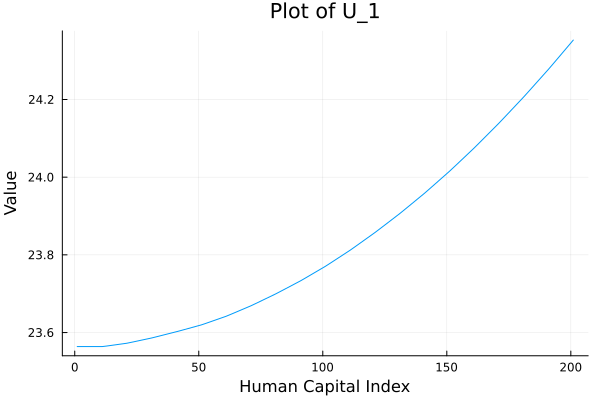

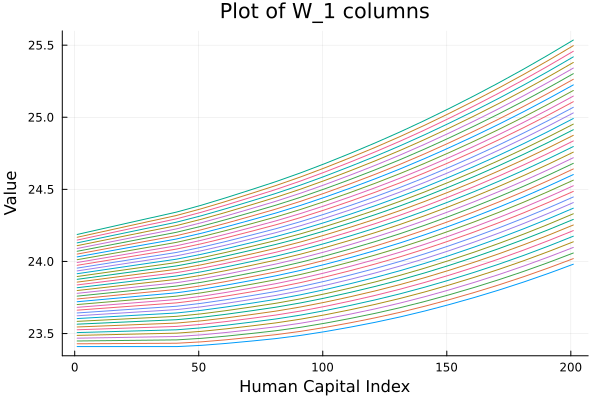

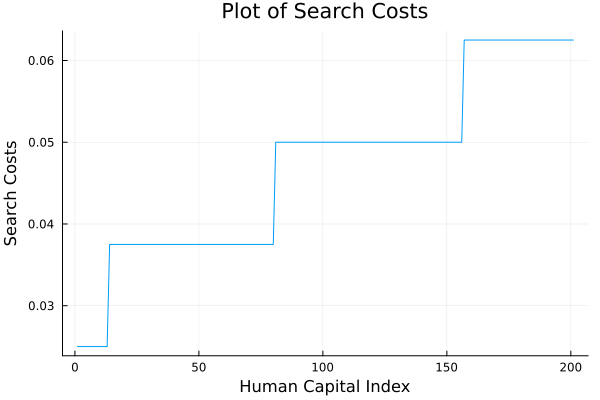

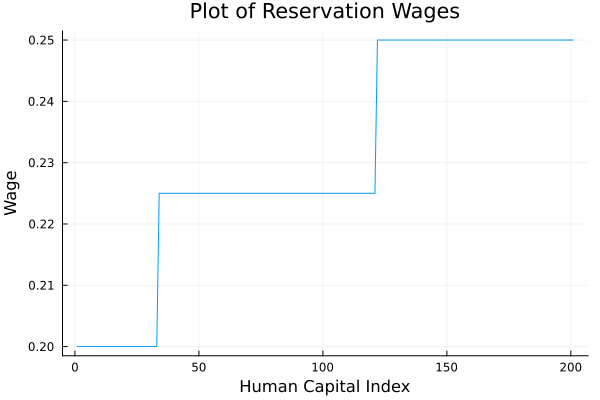

([23.40946860430581 23.428911044624996 … 24.167723776753995 24.18716621707318; 23.40946860430581 23.42900820320295 … 24.171512961294276 24.191052560191416; … ; 23.974424606948023 24.013190879552454 … 25.486309238520754 25.525075511125184; 23.980798503188634 24.01966193437102 … 25.496472319301645 25.53533575048403], [23.56383265772471; 23.56383265772471; … ; 24.345420121013362; 24.352951635251927;;], [0.025; 0.025; … ; 0.0625; 0.0625;;], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2  …  0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [71]:
@time begin
W_out, U_out, match_probs, res_wages = Bellman(Bounds, Losses, Sizes, Params, 1e-3, 1000, 0.3)
end

In [75]:
### Work in progress ###
function draw_matrices(D)

    number_of_workers, number_of_periods, seed = D[1], D[2], D[3]

    Random.seed!(seed)

    random_matrix = rand(number_of_workers, number_of_periods)

    return random_matrix

end 

draw_matrices (generic function with 2 methods)

In [76]:
simulation = draw_matrices(Draw)

10000×200 Matrix{Float64}:
 0.64056    0.780026   0.615713   …  0.857473   0.956385  0.712609
 0.324442   0.861464   0.507289      0.196291   0.72369   0.545925
 0.428415   0.274646   0.508303      0.19649    0.477554  0.735749
 0.353998   0.504371   0.746542      0.608894   0.959642  0.969716
 0.624069   0.958314   0.964312      0.680199   0.877465  0.25394
 0.609341   0.926286   0.549811   …  0.337081   0.402518  0.847767
 0.814895   0.682179   0.969977      0.619024   0.770619  0.685363
 0.858176   0.426651   0.6334        0.190008   0.969296  0.879634
 0.403735   0.905022   0.75598       0.02811    0.379111  0.659245
 0.0465632  0.0466358  0.330353      0.72518    0.744555  0.619968
 ⋮                                ⋱                       
 0.483252   0.985512   0.456219      0.352844   0.689367  0.727542
 0.0409949  0.319155   0.154516      0.434785   0.728551  0.0723237
 0.277812   0.522861   0.0928757     0.847559   0.335845  0.45882
 0.416269   0.958241   0.914777      0.38738